In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata


In [30]:
import keras
from keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf

In [3]:
sar_df = pd.read_json('Sarcasm_Headlines_Dataset.json', lines=True)
sar_df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [4]:
del sar_df['article_link']

In [5]:
#check for null values

sar_df.isnull().sum()


headline        0
is_sarcastic    0
dtype: int64

In [6]:
#check for class imbalance

sar_df.is_sarcastic.value_counts()



is_sarcastic
0    14985
1    11724
Name: count, dtype: int64

In [7]:
sar_df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [8]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [9]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
sar_df['headline']= sar_df['headline'].apply(denoise_text)

/var/folders/8r/9vsy4vnx2rl0bmgsgp823mg40000gp/T/ipykernel_48390/3686053737.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


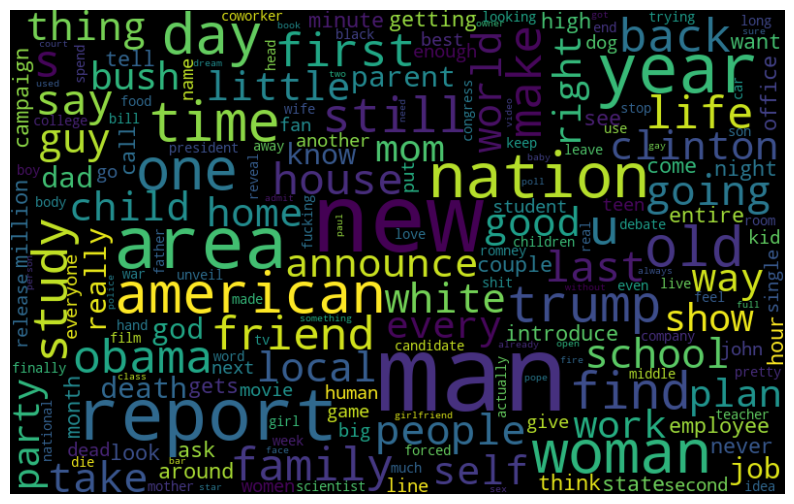

In [10]:
#wordcloud for sarcastic headlines

sar_words = ' '.join([text for text in sar_df['headline'][sar_df['is_sarcastic'] == 1]])

sar_wc = WordCloud(width = 800, height = 500, max_font_size = 110, collocations = False).generate(sar_words)

plt.figure(figsize = (10, 7))

plt.imshow(sar_wc, interpolation = 'bilinear')

plt.axis('off')

plt.show()


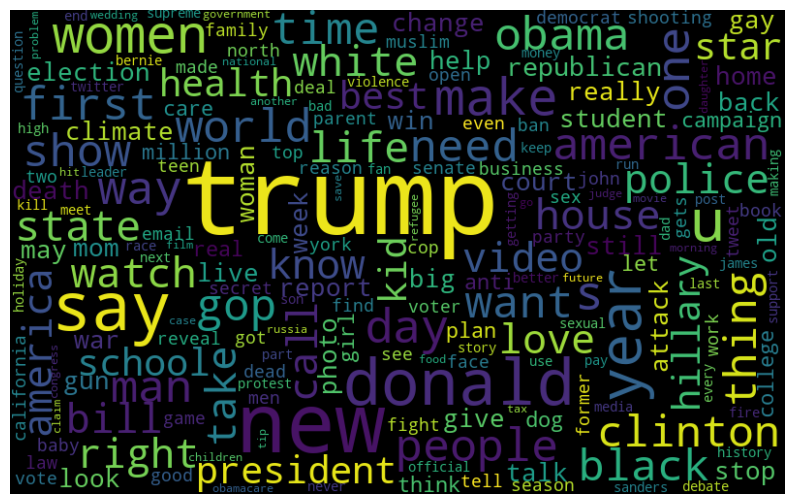

In [11]:
#wordcloud for non-sarcastic headlines

non_sar_words = ' '.join([text for text in sar_df['headline'][sar_df['is_sarcastic'] == 0]])

non_sar_wc = WordCloud(width = 800, height = 500, max_font_size = 110, collocations = False).generate(non_sar_words)

plt.figure(figsize = (10, 7))

plt.imshow(non_sar_wc, interpolation = 'bilinear')

plt.axis('off')

plt.show()



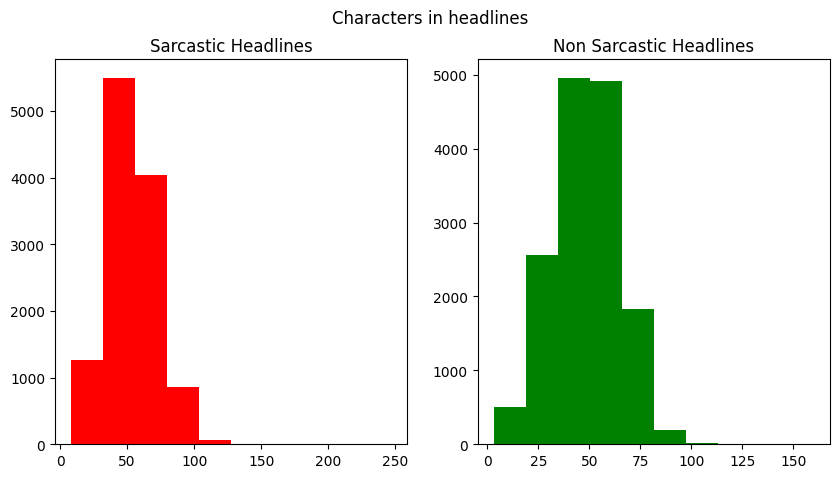

In [12]:
#Visualizing the length of sarcastic and non-sarcastic headlines

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

sar_len=sar_df[sar_df['is_sarcastic']==1]['headline'].str.len()

ax1.hist(sar_len,color='red')

ax1.set_title('Sarcastic Headlines')

non_sar_len=sar_df[sar_df['is_sarcastic']==0]['headline'].str.len()

ax2.hist(non_sar_len,color='green')

ax2.set_title('Non Sarcastic Headlines')

fig.suptitle('Characters in headlines')

plt.show()



/var/folders/8r/9vsy4vnx2rl0bmgsgp823mg40000gp/T/ipykernel_48390/3088534173.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sar_len.map(lambda x: np.mean(x)),ax=ax1,color='green')
/var/folders/8r/9vsy4vnx2rl0bmgsgp823mg40000gp/T/ipykernel_48390/3088534173.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

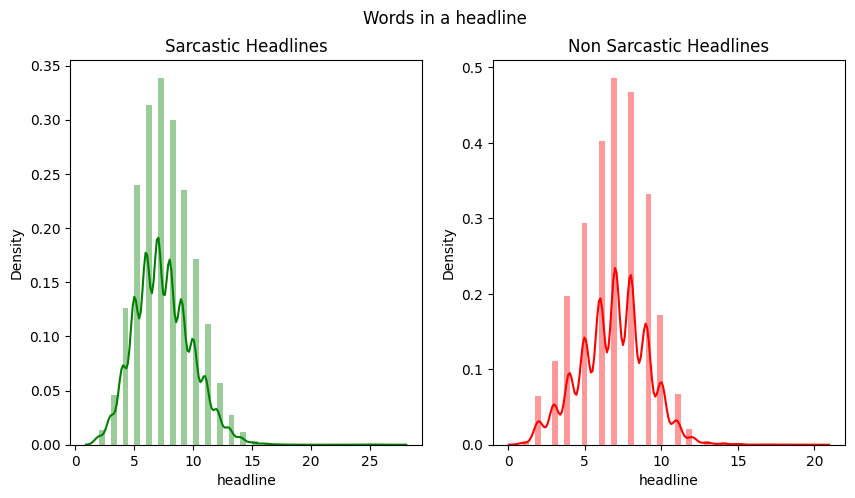

In [17]:
#Visualizing the average density of number of words in sarcastic and non-sarcastic headlines

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

sar_len=sar_df[sar_df['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x))

sns.distplot(sar_len.map(lambda x: np.mean(x)),ax=ax1,color='green')

ax1.set_title('Sarcastic Headlines')

non_sar_len=sar_df[sar_df['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x))

sns.distplot(non_sar_len.map(lambda x: np.mean(x)),ax=ax2,color='red')

ax2.set_title('Non Sarcastic Headlines')

fig.suptitle('Words in a headline')

plt.show()



In [18]:
words = []
for i in sar_df.headline.values:
    words.append(i.split())
words[:5]

[['former',
  'versace',
  'store',
  'clerk',
  'sues',
  'secret',
  "'black",
  "code'",
  'minority',
  'shoppers'],
 ["'roseanne'",
  'revival',
  'catches',
  'thorny',
  'political',
  'mood,',
  'better',
  'worse'],
 ['mom',
  'starting',
  'fear',
  "son's",
  'web',
  'series',
  'closest',
  'thing',
  'grandchild'],
 ['boehner',
  'wants',
  'wife',
  'listen,',
  'come',
  'alternative',
  'debt-reduction',
  'ideas'],
 ['j.k.', 'rowling', 'wishes', 'snape', 'happy', 'birthday', 'magical', 'way']]

In [24]:
import gensim

w2v_model=gensim.models.Word2Vec(sentences=words,vector_size=200,window=5,min_count=1)

In [27]:
len(w2v_model.wv)

36436

In [55]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = pad_sequences(tokenizer.texts_to_sequences(words), maxlen = 20)

In [56]:
vocab_size = len(tokenizer.word_index) + 1

In [57]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, 200))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]
    return weight_matrix

In [58]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

In [59]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=200, weights=[embedding_vectors], input_length=20, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
model.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [60]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 200)           7287400   
                                                                 
 bidirectional_4 (Bidirectio  (None, 20, 256)          336896    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               55680     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 7,680,041
Trainable params: 7,680,041
Non-trainable params: 0
_________________________________________________________________


In [61]:
x_train,x_test,y_train,y_test=train_test_split(tokenized_train,sar_df['is_sarcastic'],test_size=0.2,random_state=42)

In [62]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)


#Training the model

history = model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)


Epoch 1/10
134/134 [==============================] - 26s 144ms/step - loss: 0.5219 - acc: 0.7302 - val_loss: 0.4178 - val_acc: 0.8046
Epoch 2/10
134/134 [==============================] - 18s 133ms/step - loss: 0.1446 - acc: 0.9452 - val_loss: 0.5548 - val_acc: 0.7784
Epoch 3/10
134/134 [==============================] - 18s 133ms/step - loss: 0.0326 - acc: 0.9887 - val_loss: 0.9437 - val_acc: 0.7815
Epoch 4/10
134/134 [==============================] - 21s 154ms/step - loss: 0.0092 - acc: 0.9965 - val_loss: 1.2474 - val_acc: 0.7871
Epoch 5/10
134/134 [==============================] - 20s 147ms/step - loss: 0.0064 - acc: 0.9981 - val_loss: 1.2426 - val_acc: 0.7777
Epoch 6/10
134/134 [==============================] - 19s 145ms/step - loss: 0.0048 - acc: 0.9985 - val_loss: 1.2635 - val_acc: 0.7843
Epoch 7/10
134/134 [==============================] - 18s 134ms/step - loss: 0.0033 - acc: 0.9989 - val_loss: 1.4431 - val_acc: 0.7787
Epoch 8/10
134/134 [==============================] - 1

In [63]:
print('Accuracy of the model on Training Data is - ' , model.evaluate(x_train,y_train)[1]*100 , '%')

print('Accuracy of the model on Testing Data is - ' , model.evaluate(x_test,y_test)[1]*100 , '%')



668/668 [==============================] - 7s 11ms/step - loss: 0.3370 - acc: 0.9561
Accuracy of the model on Training Data is -  95.61005234718323 %
167/167 [==============================] - 2s 10ms/step - loss: 1.6005 - acc: 0.7868
Accuracy of the model on Testing Data is -  78.67839932441711 %


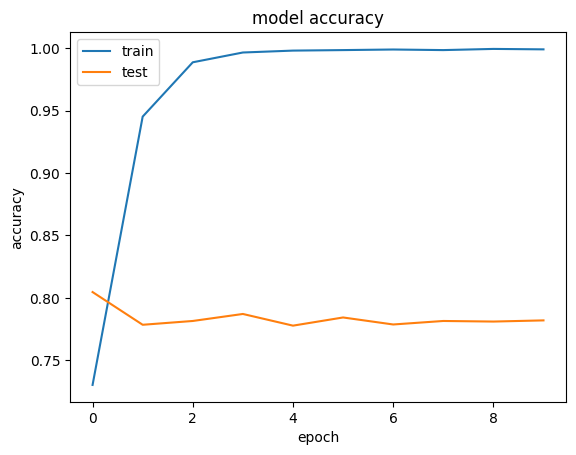

In [64]:
#plotting the loss and accuracy of the model

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')

plt.ylabel('accuracy')

plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left')

plt.show()



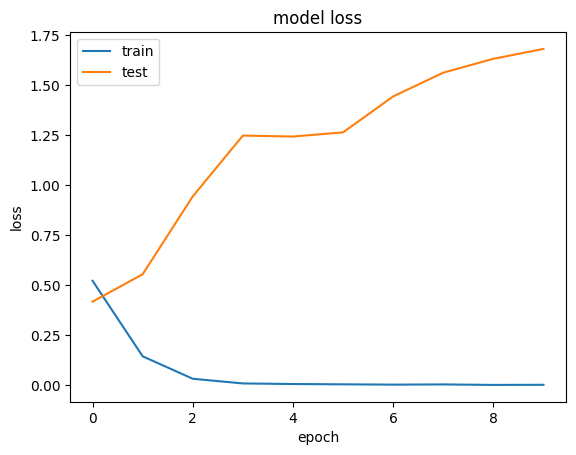

In [65]:
#plotting the training and testing loss

plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])

plt.title('model loss')

plt.ylabel('loss')

plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left')

plt.show()

In [68]:
# Perform predictions
pred_probs = model.predict(x_test)

# Convert probabilities to class labels
threshold = 0.5  # Adjust the threshold as needed
pred = (pred_probs >= threshold).astype(int)

# Display the first 5 predicted class labels
print(pred[:5])

167/167 [==============================] - 3s 11ms/step
[[1]
 [0]
 [1]
 [0]
 [0]]


In [69]:
cm = confusion_matrix(y_test, pred)
print(cm)

[[2486  510]
 [ 629 1717]]


<Axes: >

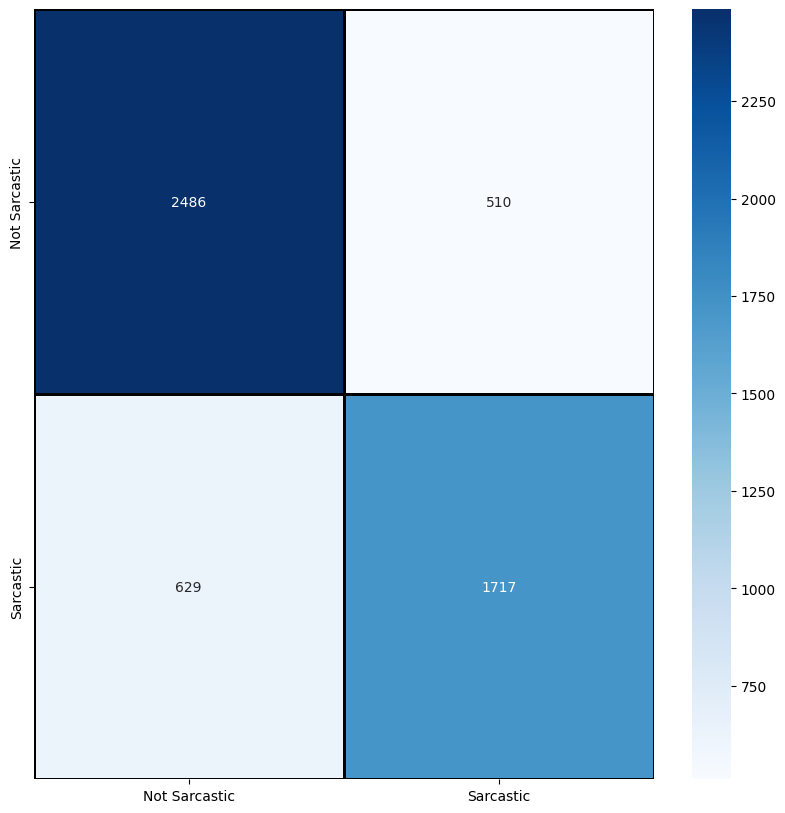

In [70]:
m = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])

In [170]:
x_train, x_test, y_train, y_test = train_test_split(sar_df.headline, sar_df.is_sarcastic, test_size=0.3, random_state=0)

max_features = 35000
maxlen = 200

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


x_train shape: (18696,)
x_test shape: (8013,)
y_train shape: (18696,)
y_test shape: (8013,)


In [171]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

tokenizer = Tokenizer(num_words=35000)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

tokenized_test = tokenizer.texts_to_sequences(x_test)
x_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

print("x_train shape after padding:", x_train.shape)
print("x_test shape after padding:", x_test.shape)


x_train shape after padding: (18696, 200)
x_test shape after padding: (8013, 200)


In [172]:
EMBEDDING_FILE = 'glove.6B.200d.txt'

In [173]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [174]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/Users/omkar/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


In [175]:
batch_size = 128
epochs = 2
embed_size = 200

#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(nb_words, output_dim=embed_size, weights=[embedding_matrix], input_length=200, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.5 , dropout = 0.5)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [176]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 200, 200)          4945000   
                                                                 
 bidirectional_15 (Bidirecti  (None, 256)              336896    
 onal)                                                           
                                                                 
 dense_12 (Dense)            (None, 1)                 257       
                                                                 
Total params: 5,282,153
Trainable params: 5,282,153
Non-trainable params: 0
_________________________________________________________________


In [177]:
history = model.fit(x_train, y_train, batch_size=batch_size, validation_data= (x_test, y_test), epochs=epochs)

print('Accuracy of the model on Training Data is - ' , model.evaluate(x_train,y_train)[1]*100 , '%')

print('Accuracy of the model on Testing Data is - ' , model.evaluate(x_test,y_test)[1]*100 , '%')



Epoch 1/2
 27/147 [====>.........................] - ETA: 1:40 - loss: 0.7800 - acc: 0.5830

2023-07-15 17:12:43.281745: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: indices[99,195] = 24725 is not in [0, 24725)
	 [[{{node sequential_20/embedding_19/embedding_lookup}}]]


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_20/embedding_19/embedding_lookup' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "/Users/omkar/Library/Python/3.11/lib/python/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/omkar/Library/Python/3.11/lib/python/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/omkar/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelapp.py", line 728, in start
      self.io_loop.start()
    File "/Users/omkar/Library/Python/3.11/lib/python/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
      self._run_once()
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once
      handle._run()
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/omkar/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/Users/omkar/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/Users/omkar/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/Users/omkar/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/Users/omkar/Library/Python/3.11/lib/python/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/Users/omkar/Library/Python/3.11/lib/python/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/omkar/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/Users/omkar/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/Users/omkar/Library/Python/3.11/lib/python/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/omkar/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/omkar/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/omkar/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/8r/9vsy4vnx2rl0bmgsgp823mg40000gp/T/ipykernel_48390/1846990497.py", line 1, in <module>
      history = model.fit(x_train, y_train, batch_size=batch_size, validation_data= (x_test, y_test), epochs=epochs)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/engine/training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/engine/sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/layers/core/embedding.py", line 272, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'sequential_20/embedding_19/embedding_lookup'
indices[99,195] = 24725 is not in [0, 24725)
	 [[{{node sequential_20/embedding_19/embedding_lookup}}]] [Op:__inference_train_function_89720]